# <center> </center>
# <center> **Computer Vision** </center>
# <center> **Portfolio Exam 3**</center>
# <center>**Implement and analyze a Variational Autoencoder on CelebA**</center>

**Latent Dim = 512**
**Beta = 1**


**Submitted by:**
****

*   **Riya Biju - 10000742**
*   **Harsha Sathish - 10001000**
*   **Harshith Babu Prakash Babu - 10001191**


In [ ]:
"""
VAE Implementation for CelebA Dataset - Portfolio 3 Phase 1
Baseline model with latent_dim = 512
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ============================================================================
# Dataset Class
# ============================================================================

class CelebADataset(Dataset):
    """
    Custom Dataset for CelebA aligned and cropped images
    """
    def __init__(self, root_dir, partition_file, split='train', transform=None, subset_size=None):
        """
        Args:
            root_dir: Path to CelebA directory
            partition_file: Path to list_eval_partition.txt
            split: 'train', 'val', or 'test' (0, 1, 2 in partition file)
            transform: Transformations to apply
            subset_size: If specified, use only this many images (for faster training)
        """
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'Img', 'img_align_celeba')
        self.transform = transform
        
        # Load partition information
        self.image_files = []
        split_map = {'train': 0, 'val': 1, 'test': 2}
        split_id = split_map[split]
        
        with open(partition_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 2:
                    img_name, partition = parts
                    if int(partition) == split_id:
                        self.image_files.append(img_name)
        
        # Apply subset if specified
        if subset_size is not None and subset_size < len(self.image_files):
            np.random.seed(42)
            indices = np.random.choice(len(self.image_files), subset_size, replace=False)
            self.image_files = [self.image_files[i] for i in sorted(indices)]
        
        print(f"{split.upper()} set: {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image


# ============================================================================
# VAE Model Architecture
# ============================================================================

class VAE(nn.Module):
    """
    Convolutional Variational Autoencoder for CelebA (64x64 images)
    """
    def __init__(self, latent_dim=512, img_channels=3):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # ====== ENCODER ======
        # Input: (3, 64, 64)
        self.encoder = nn.Sequential(
            # Layer 1: (3, 64, 64) -> (32, 32, 32)
            nn.Conv2d(img_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2: (32, 32, 32) -> (64, 16, 16)
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3: (64, 16, 16) -> (128, 8, 8)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4: (128, 8, 8) -> (256, 4, 4)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Flattened feature size: 256 * 4 * 4 = 4096
        self.fc_encoder = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True)
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
        
        # ====== DECODER ======
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256 * 4 * 4),
            nn.ReLU(inplace=True)
        )
        
        # Decoder: Mirror of encoder
        self.decoder = nn.Sequential(
            # Layer 1: (256, 4, 4) -> (128, 8, 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # Layer 2: (128, 8, 8) -> (64, 16, 16)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Layer 3: (64, 16, 16) -> (32, 32, 32)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Layer 4: (32, 32, 32) -> (3, 64, 64)
            nn.ConvTranspose2d(32, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in [0, 1]
        )
    
    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        h = self.fc_encoder(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + std * epsilon"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent vector to image"""
        h = self.fc_decoder(z)
        h = h.view(h.size(0), 256, 4, 4)  # Reshape
        return self.decoder(h)
    
    def forward(self, x):
        """Full forward pass"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


# ============================================================================
# Loss Function - CORRECTED VERSION
# ============================================================================
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE Loss - Production Ready Version
    """
    batch_size = x.size(0)
    
    
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / batch_size
    # Per-pixel for display
    recon_loss_display = recon_loss / (x.size(1) * x.size(2) * x.size(3))
    
    # KL Divergence
    # Sum over latent dims, mean over batch
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
    
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss_display, kl_loss



# ============================================================================
# Training Function 
# ============================================================================

def train_epoch(model, train_loader, optimizer, epoch, beta=1.0):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, data in enumerate(pbar):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
        
        if kl_loss.item() < 1.0 and epoch > 1:
            print(f"\n⚠️ WARNING: KL collapsed at epoch {epoch}, batch {batch_idx}")
            print(f"   KL: {kl_loss.item():.6f}")
            print(f"   mu range: [{mu.min():.4f}, {mu.max():.4f}]")
            print(f"   logvar range: [{logvar.min():.4f}, {logvar.max():.4f}]")
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate losses
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Recon': f'{recon_loss.item():.4f}',
            'KL': f'{kl_loss.item():.4f}'
        })
    
    # Average losses
    n_batches = len(train_loader)
    return train_loss / n_batches, train_recon_loss / n_batches, train_kl_loss / n_batches


def validate(model, val_loader, beta=1.0):
    """Validate the model"""
    model.eval()
    val_loss = 0
    val_recon_loss = 0
    val_kl_loss = 0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_kl_loss += kl_loss.item()
    
    # Average losses
    n_batches = len(val_loader)
    return val_loss / n_batches, val_recon_loss / n_batches, val_kl_loss / n_batches


# ============================================================================
# Visualization Functions
# ============================================================================

def save_sample_images(model, val_loader, epoch, save_dir, num_samples=8):
    """Save sample reconstructions"""
    model.eval()
    
    # Get a batch
    data = next(iter(val_loader))[:num_samples].to(device)
    
    with torch.no_grad():
        recon, _, _ = model(data)
    
    # Move to CPU and denormalize
    data = data.cpu()
    recon = recon.cpu()
    
    # Create figure
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    
    for i in range(num_samples):
        # Original
        axes[0, i].imshow(data[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)
        
        # Reconstruction
        axes[1, i].imshow(recon[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'reconstruction_epoch_{epoch}.png'), dpi=100, bbox_inches='tight')
    plt.close()


def plot_training_curves(history, save_dir):
    """Plot and save training curves"""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Total Loss
    axes[0].plot(epochs, history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Total Loss')
    axes[0].set_title('Total Loss (ELBO)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Reconstruction Loss
    axes[1].plot(epochs, history['train_recon'], label='Train', linewidth=2)
    axes[1].plot(epochs, history['val_recon'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Reconstruction Loss')
    axes[1].set_title('Reconstruction Loss (BCE)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # KL Divergence
    axes[2].plot(epochs, history['train_kl'], label='Train', linewidth=2)
    axes[2].plot(epochs, history['val_kl'], label='Validation', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('KL Divergence')
    axes[2].set_title('KL Divergence')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.close()


# ============================================================================
# Main Training Script
# ============================================================================

def main():
    # ========== Configuration ==========
    config = {
        'latent_dim': 512,
        'beta': 1.0,  
        'img_size': 64,
        'batch_size': 128,
        'num_epochs': 50,
        'learning_rate': 1e-3,
        'subset_train': 50000,  # Use 50k training images (adjust as needed)
        'subset_val': 5000,     # Use 5k validation images
        'num_workers': 0,       # DataLoader workers
        'save_interval': 5,     # Save checkpoint every N epochs
    }
    
    print("=" * 60)
    print("VAE Training Configuration")
    print("=" * 60)
    for key, value in config.items():
        print(f"{key:20s}: {value}")
    print("=" * 60)
    
    # ========== Paths ==========
    celeba_root = './CelebA'  # Adjust if needed
    partition_file = os.path.join(celeba_root, 'Eval', 'list_eval_partition.txt')
    
    # Create output directories
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'./outputs_512/vae_baseline_latent{config["latent_dim"]}_{timestamp}'
    checkpoint_dir = os.path.join(output_dir, 'checkpoints')
    sample_dir = os.path.join(output_dir, 'samples')
    
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)
    
    # Save configuration
    with open(os.path.join(output_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=4)
    
    # ========== Data Transforms ==========
    transform = transforms.Compose([
        transforms.Resize(config['img_size']),
        transforms.CenterCrop(config['img_size']),
        transforms.ToTensor(),
    ])
    
    # ========== Datasets and DataLoaders ==========
    print("\nLoading datasets...")
    train_dataset = CelebADataset(
        root_dir=celeba_root,
        partition_file=partition_file,
        split='train',
        transform=transform,
        subset_size=config['subset_train']
    )
    
    val_dataset = CelebADataset(
        root_dir=celeba_root,
        partition_file=partition_file,
        split='val',
        transform=transform,
        subset_size=config['subset_val']
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    # ========== Model Setup ==========
    print("\nInitializing model...")
    model = VAE(latent_dim=config['latent_dim']).to(device)
    
    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # ========== Training Loop ==========
    print("\n" + "=" * 60)
    print("Starting Training")
    print("=" * 60)
    
    history = {
        'train_loss': [], 'train_recon': [], 'train_kl': [],
        'val_loss': [], 'val_recon': [], 'val_kl': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(1, config['num_epochs'] + 1):
        # Train
        train_loss, train_recon, train_kl = train_epoch(
            model, train_loader, optimizer, epoch, beta=config['beta']
        )
        
        # Validate
        val_loss, val_recon, val_kl = validate(model, val_loader, beta=config['beta'])
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_recon'].append(train_recon)
        history['train_kl'].append(train_kl)
        history['val_loss'].append(val_loss)
        history['val_recon'].append(val_recon)
        history['val_kl'].append(val_kl)
        
        # Print epoch summary
        print(f"\nEpoch {epoch}/{config['num_epochs']}:")
        print(f"  Train - Loss: {train_loss:.4f}, Recon: {train_recon:.4f}, KL: {train_kl:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Recon: {val_recon:.4f}, KL: {val_kl:.4f}")
        
        if val_kl < 10.0:
            print(f"  ⚠️  WARNING: KL very low ({val_kl:.4f}) - monitor for collapse")
        elif val_kl > 200.0:
            print(f"  ⚠️  WARNING: KL very high ({val_kl:.4f}) - model may ignore inputs")
        
        # Save sample reconstructions
        if epoch % config['save_interval'] == 0:
            save_sample_images(model, val_loader, epoch, sample_dir)
        
        # Save checkpoint
        if epoch % config['save_interval'] == 0 or epoch == config['num_epochs']:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'config': config,
                'history': history,
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
            torch.save(checkpoint, checkpoint_path)
            print(f"  Saved checkpoint: {checkpoint_path}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'config': config,
                'history': history,
                'val_loss': val_loss,
            }
            best_path = os.path.join(checkpoint_dir, 'best_model.pth')
            torch.save(best_checkpoint, best_path)
            print(f"  ⭐ New best model saved! Val Loss: {val_loss:.4f}")
    
    # ========== Final Steps ==========
    print("\n" + "=" * 60)
    print("Training Complete!")
    print("=" * 60)
    
    # Plot training curves
    plot_training_curves(history, output_dir)
    print(f"\nTraining curves saved to: {output_dir}/training_curves.png")
    
    # Save final model
    final_checkpoint = {
        'epoch': config['num_epochs'],
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'config': config,
        'history': history,
    }
    final_path = os.path.join(checkpoint_dir, 'final_model.pth')
    torch.save(final_checkpoint, final_path)
    print(f"Final model saved to: {final_path}")
    
    # Save training history
    with open(os.path.join(output_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f, indent=4)
    
    print(f"\nAll outputs saved to: {output_dir}")
    print(f"Best validation loss: {best_val_loss:.4f}")


if __name__ == '__main__':
    main()

Using device: cpu
VAE Training Configuration
latent_dim          : 512
beta                : 1.0
img_size            : 64
batch_size          : 128
num_epochs          : 50
learning_rate       : 0.001
subset_train        : 50000
subset_val          : 5000
num_workers         : 0
save_interval       : 5

Loading datasets...
TRAIN set: 50000 images
VAL set: 5000 images

Initializing model...
Total parameters: 8,728,131
Trainable parameters: 8,728,131

Starting Training


Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]/Users/harshasathish/Desktop/MAI/ComputerVision/Portfolio3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1: 100%|██████████| 391/391 [02:09<00:00,  3.03it/s, Loss=6764.2686, Recon=0.5446, KL=72.5497]



Epoch 1/50:
  Train - Loss: 7064.2787, Recon: 0.5701, KL: 58.7325
  Val   - Loss: 6850.0257, Recon: 0.5514, KL: 73.9187
  ⭐ New best model saved! Val Loss: 6850.0257


Epoch 2: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s, Loss=6624.5737, Recon=0.5336, KL=67.9773]



Epoch 2/50:
  Train - Loss: 6732.8142, Recon: 0.5422, KL: 70.3085
  Val   - Loss: 6727.8730, Recon: 0.5423, KL: 63.8253
  ⭐ New best model saved! Val Loss: 6727.8730


Epoch 3: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=6684.6992, Recon=0.5390, KL=61.1866]



Epoch 3/50:
  Train - Loss: 6671.3028, Recon: 0.5379, KL: 61.8295
  Val   - Loss: 6670.3703, Recon: 0.5383, KL: 55.3087
  ⭐ New best model saved! Val Loss: 6670.3703


Epoch 4: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, Loss=6663.2720, Recon=0.5381, KL=50.8373]



Epoch 4/50:
  Train - Loss: 6632.8638, Recon: 0.5353, KL: 54.6905
  Val   - Loss: 6631.6404, Recon: 0.5353, KL: 53.4765
  ⭐ New best model saved! Val Loss: 6631.6404


Epoch 5: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, Loss=6694.3271, Recon=0.5411, KL=45.4223]



Epoch 5/50:
  Train - Loss: 6609.2827, Recon: 0.5339, KL: 48.5023
  Val   - Loss: 6610.6012, Recon: 0.5342, KL: 45.8501
  Saved checkpoint: ./outputs_512/vae_baseline_latent512_20260101_152701/checkpoints/checkpoint_epoch_5.pth
  ⭐ New best model saved! Val Loss: 6610.6012


Epoch 6: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=6697.6870, Recon=0.5415, KL=43.4854]



Epoch 6/50:
  Train - Loss: 6593.0657, Recon: 0.5329, KL: 44.8797
  Val   - Loss: 6613.2925, Recon: 0.5347, KL: 43.1616


Epoch 7: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, Loss=6647.5107, Recon=0.5375, KL=42.2558]



Epoch 7/50:
  Train - Loss: 6581.9468, Recon: 0.5322, KL: 42.7714
  Val   - Loss: 6591.2370, Recon: 0.5329, KL: 42.8813
  ⭐ New best model saved! Val Loss: 6591.2370


Epoch 8: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s, Loss=6480.9189, Recon=0.5241, KL=40.4769]



Epoch 8/50:
  Train - Loss: 6576.6627, Recon: 0.5318, KL: 41.8664
  Val   - Loss: 6602.6865, Recon: 0.5339, KL: 41.6249


Epoch 9: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s, Loss=6575.5288, Recon=0.5319, KL=40.0407]



Epoch 9/50:
  Train - Loss: 6571.2708, Recon: 0.5314, KL: 41.2348
  Val   - Loss: 6590.3105, Recon: 0.5329, KL: 42.4232
  ⭐ New best model saved! Val Loss: 6590.3105


Epoch 10: 100%|██████████| 391/391 [02:11<00:00,  2.98it/s, Loss=6462.8442, Recon=0.5227, KL=40.1360]



Epoch 10/50:
  Train - Loss: 6566.7114, Recon: 0.5311, KL: 40.5478
  Val   - Loss: 6598.9329, Recon: 0.5337, KL: 41.1693
  Saved checkpoint: ./outputs_512/vae_baseline_latent512_20260101_152701/checkpoints/checkpoint_epoch_10.pth


Epoch 11: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s, Loss=6446.6870, Recon=0.5214, KL=39.9644]



Epoch 11/50:
  Train - Loss: 6562.9534, Recon: 0.5308, KL: 40.1291
  Val   - Loss: 6577.7578, Recon: 0.5321, KL: 39.8895
  ⭐ New best model saved! Val Loss: 6577.7578


Epoch 12: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s, Loss=6601.7363, Recon=0.5340, KL=40.3487]



Epoch 12/50:
  Train - Loss: 6560.0513, Recon: 0.5306, KL: 39.9660
  Val   - Loss: 6579.2066, Recon: 0.5321, KL: 41.2601


Epoch 13: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s, Loss=6541.2466, Recon=0.5291, KL=39.8268]



Epoch 13/50:
  Train - Loss: 6556.9101, Recon: 0.5304, KL: 39.8952
  Val   - Loss: 6574.2525, Recon: 0.5318, KL: 39.1789
  ⭐ New best model saved! Val Loss: 6574.2525


Epoch 14: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s, Loss=6459.0269, Recon=0.5224, KL=39.9275]



Epoch 14/50:
  Train - Loss: 6554.1338, Recon: 0.5301, KL: 39.7752
  Val   - Loss: 6570.9315, Recon: 0.5316, KL: 39.2181
  ⭐ New best model saved! Val Loss: 6570.9315


Epoch 15: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s, Loss=6626.0791, Recon=0.5360, KL=39.3576]



Epoch 15/50:
  Train - Loss: 6552.2099, Recon: 0.5300, KL: 39.8048
  Val   - Loss: 6575.8884, Recon: 0.5320, KL: 39.0869
  Saved checkpoint: ./outputs_512/vae_baseline_latent512_20260101_152701/checkpoints/checkpoint_epoch_15.pth


Epoch 16: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s, Loss=6503.9062, Recon=0.5260, KL=40.3986]



Epoch 16/50:
  Train - Loss: 6549.6864, Recon: 0.5298, KL: 39.7806
  Val   - Loss: 6576.4426, Recon: 0.5320, KL: 39.1427


Epoch 17: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s, Loss=6528.5928, Recon=0.5281, KL=38.8342]



Epoch 17/50:
  Train - Loss: 6547.4906, Recon: 0.5296, KL: 39.6922
  Val   - Loss: 6577.2008, Recon: 0.5320, KL: 39.9211


Epoch 18: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=6502.9893, Recon=0.5260, KL=39.9612]



Epoch 18/50:
  Train - Loss: 6546.6918, Recon: 0.5295, KL: 39.7429
  Val   - Loss: 6568.5114, Recon: 0.5313, KL: 40.0380
  ⭐ New best model saved! Val Loss: 6568.5114


Epoch 19: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s, Loss=6512.3232, Recon=0.5268, KL=39.4851]



Epoch 19/50:
  Train - Loss: 6543.6158, Recon: 0.5293, KL: 39.7346
  Val   - Loss: 6572.9460, Recon: 0.5317, KL: 38.9679


Epoch 20: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s, Loss=6665.2241, Recon=0.5391, KL=40.8572]



Epoch 20/50:
  Train - Loss: 6541.9793, Recon: 0.5292, KL: 39.7543
  Val   - Loss: 6574.2801, Recon: 0.5318, KL: 39.7279
  Saved checkpoint: ./outputs_512/vae_baseline_latent512_20260101_152701/checkpoints/checkpoint_epoch_20.pth


Epoch 21: 100%|██████████| 391/391 [02:12<00:00,  2.96it/s, Loss=6539.6387, Recon=0.5289, KL=40.3055]



Epoch 21/50:
  Train - Loss: 6540.2103, Recon: 0.5290, KL: 39.8013
  Val   - Loss: 6569.9836, Recon: 0.5314, KL: 39.5452


Epoch 22: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s, Loss=6531.6099, Recon=0.5284, KL=38.7375]



Epoch 22/50:
  Train - Loss: 6539.0378, Recon: 0.5289, KL: 39.7704
  Val   - Loss: 6569.2148, Recon: 0.5314, KL: 39.7077


Epoch 23: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s, Loss=6638.3730, Recon=0.5371, KL=38.6803]



Epoch 23/50:
  Train - Loss: 6537.1789, Recon: 0.5288, KL: 39.7166
  Val   - Loss: 6568.2404, Recon: 0.5314, KL: 38.7077
  ⭐ New best model saved! Val Loss: 6568.2404


Epoch 24: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=6523.5728, Recon=0.5276, KL=40.5445]



Epoch 24/50:
  Train - Loss: 6535.1540, Recon: 0.5286, KL: 39.7200
  Val   - Loss: 6568.5491, Recon: 0.5313, KL: 39.4095


Epoch 25: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, Loss=6480.5186, Recon=0.5242, KL=38.6866]



Epoch 25/50:
  Train - Loss: 6523.9442, Recon: 0.5277, KL: 39.1697
  Val   - Loss: 6561.4574, Recon: 0.5308, KL: 38.9794
  Saved checkpoint: ./outputs_512/vae_baseline_latent512_20260101_152701/checkpoints/checkpoint_epoch_25.pth
  ⭐ New best model saved! Val Loss: 6561.4574


Epoch 26: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s, Loss=6282.5864, Recon=0.5081, KL=39.2128]



Epoch 26/50:
  Train - Loss: 6521.6873, Recon: 0.5276, KL: 39.0252
  Val   - Loss: 6560.5410, Recon: 0.5307, KL: 38.7823
  ⭐ New best model saved! Val Loss: 6560.5410


Epoch 27: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s, Loss=6584.2666, Recon=0.5327, KL=37.9809]



Epoch 27/50:
  Train - Loss: 6520.5898, Recon: 0.5275, KL: 39.0466
  Val   - Loss: 6558.3807, Recon: 0.5306, KL: 38.7103
  ⭐ New best model saved! Val Loss: 6558.3807


Epoch 28: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, Loss=6587.3770, Recon=0.5329, KL=39.7000]



Epoch 28/50:
  Train - Loss: 6519.6697, Recon: 0.5274, KL: 39.0937
  Val   - Loss: 6564.0855, Recon: 0.5310, KL: 38.7950


Epoch 29: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=6483.8159, Recon=0.5245, KL=38.6967]



Epoch 29/50:
  Train - Loss: 6519.2505, Recon: 0.5274, KL: 39.0925
  Val   - Loss: 6562.4132, Recon: 0.5309, KL: 38.9992


Epoch 30: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, Loss=6549.7422, Recon=0.5298, KL=39.0833]



Epoch 30/50:
  Train - Loss: 6517.8465, Recon: 0.5272, KL: 39.1279
  Val   - Loss: 6561.9321, Recon: 0.5308, KL: 38.9979
  Saved checkpoint: ./outputs_512/vae_baseline_latent512_20260101_152701/checkpoints/checkpoint_epoch_30.pth


Epoch 31: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=6827.9575, Recon=0.5525, KL=39.2686]



Epoch 31/50:
  Train - Loss: 6516.3952, Recon: 0.5271, KL: 39.1453
  Val   - Loss: 6573.1495, Recon: 0.5317, KL: 39.4034


Epoch 32: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=6606.2192, Recon=0.5343, KL=40.1269]



Epoch 32/50:
  Train - Loss: 6515.8053, Recon: 0.5271, KL: 39.2421
  Val   - Loss: 6563.6223, Recon: 0.5310, KL: 39.2331


Epoch 33: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, Loss=6490.7427, Recon=0.5250, KL=39.8145]



Epoch 33/50:
  Train - Loss: 6514.5832, Recon: 0.5270, KL: 39.2489
  Val   - Loss: 6568.5857, Recon: 0.5314, KL: 38.8974


Epoch 34: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=6497.7612, Recon=0.5256, KL=39.1925]



Epoch 34/50:
  Train - Loss: 6507.6204, Recon: 0.5264, KL: 39.0654
  Val   - Loss: 6557.4172, Recon: 0.5305, KL: 38.7032
  ⭐ New best model saved! Val Loss: 6557.4172


Epoch 35: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, Loss=6355.0142, Recon=0.5140, KL=39.0502]



Epoch 35/50:
  Train - Loss: 6505.8406, Recon: 0.5263, KL: 39.0699
  Val   - Loss: 6557.8641, Recon: 0.5305, KL: 38.6934
  Saved checkpoint: ./outputs_512/vae_baseline_latent512_20260101_152701/checkpoints/checkpoint_epoch_35.pth


Epoch 36: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=6584.5264, Recon=0.5327, KL=38.9548]



Epoch 36/50:
  Train - Loss: 6504.8920, Recon: 0.5262, KL: 39.0315
  Val   - Loss: 6558.8135, Recon: 0.5306, KL: 38.6555


Epoch 37: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s, Loss=6266.5068, Recon=0.5068, KL=39.0037]



Epoch 37/50:
  Train - Loss: 6504.2065, Recon: 0.5261, KL: 39.0226
  Val   - Loss: 6557.4418, Recon: 0.5305, KL: 38.7125


Epoch 38: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s, Loss=6461.6660, Recon=0.5226, KL=39.7131]



Epoch 38/50:
  Train - Loss: 6503.9311, Recon: 0.5261, KL: 39.1024
  Val   - Loss: 6558.5056, Recon: 0.5306, KL: 38.9384


Epoch 39: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s, Loss=6360.4434, Recon=0.5144, KL=39.1735]



Epoch 39/50:
  Train - Loss: 6502.8948, Recon: 0.5260, KL: 39.1517
  Val   - Loss: 6559.6076, Recon: 0.5307, KL: 38.8178


Epoch 40: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s, Loss=6495.6094, Recon=0.5254, KL=38.8969]



Epoch 40/50:
  Train - Loss: 6502.5395, Recon: 0.5260, KL: 39.1766
  Val   - Loss: 6559.3610, Recon: 0.5307, KL: 38.7136
  Saved checkpoint: ./outputs_512/vae_baseline_latent512_20260101_152701/checkpoints/checkpoint_epoch_40.pth


Epoch 41: 100%|██████████| 391/391 [02:15<00:00,  2.88it/s, Loss=6491.6353, Recon=0.5251, KL=39.0227]



Epoch 41/50:
  Train - Loss: 6498.2709, Recon: 0.5256, KL: 39.1400
  Val   - Loss: 6557.3573, Recon: 0.5305, KL: 38.5088
  ⭐ New best model saved! Val Loss: 6557.3573


Epoch 42: 100%|██████████| 391/391 [02:15<00:00,  2.89it/s, Loss=6349.5894, Recon=0.5136, KL=38.2583]



Epoch 42/50:
  Train - Loss: 6497.5661, Recon: 0.5256, KL: 39.1328
  Val   - Loss: 6557.4473, Recon: 0.5305, KL: 38.8242


Epoch 43: 100%|██████████| 391/391 [02:08<00:00,  3.04it/s, Loss=6563.5845, Recon=0.5311, KL=37.8480]



Epoch 43/50:
  Train - Loss: 6497.1294, Recon: 0.5256, KL: 39.1164
  Val   - Loss: 6558.0029, Recon: 0.5305, KL: 38.6238


Epoch 44: 100%|██████████| 391/391 [02:09<00:00,  3.02it/s, Loss=6397.2749, Recon=0.5174, KL=39.0794]



Epoch 44/50:
  Train - Loss: 6496.8417, Recon: 0.5255, KL: 39.1547
  Val   - Loss: 6558.7500, Recon: 0.5306, KL: 38.6914


Epoch 45:  13%|█▎        | 51/391 [00:17<01:52,  3.01it/s, Loss=6492.8643, Recon=0.5252, KL=39.2498]

VAE Model Testing and Visualization

Using output directory: ./outputs/vae_baseline_latent128_20251231_170110
Loading BEST model: ./outputs/vae_baseline_latent128_20251231_170110/checkpoints/best_model.pth

Loading Trained Model
✅ Model loaded successfully!
   Epoch: 44
   Latent dimension: 128
   Validation loss: 6348.0464

Loading Test Dataset
TEST set: 2000 images
✅ Test dataset loaded: 2000 images

Generating Reconstructions


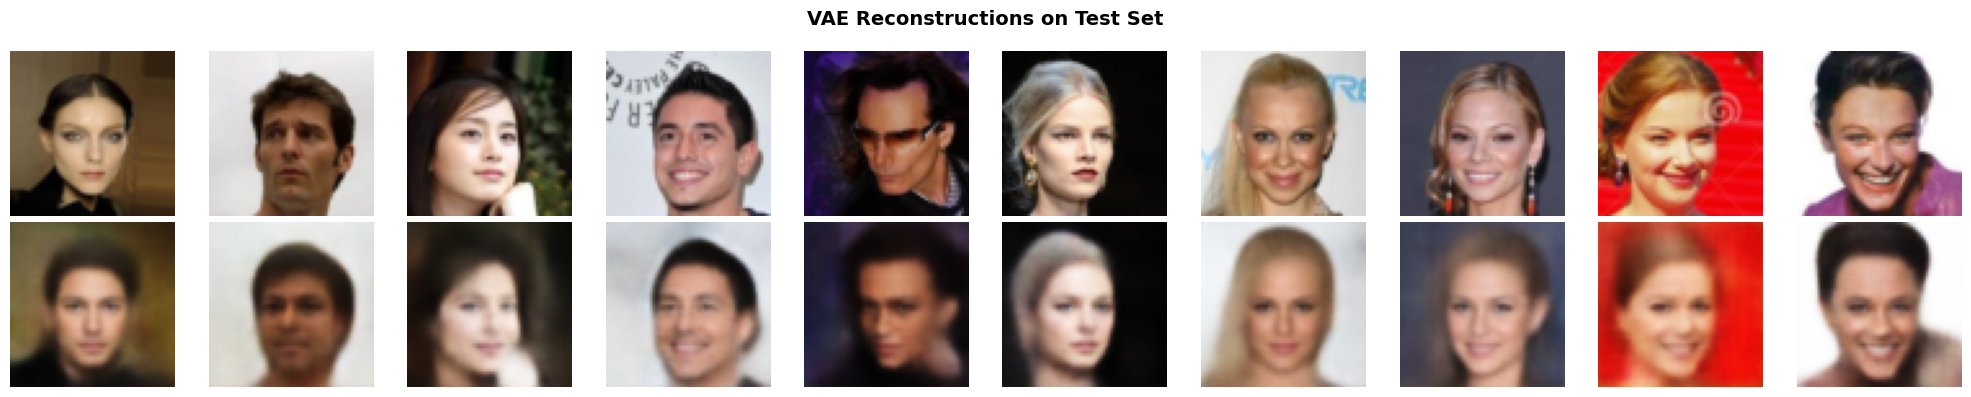

✅ Reconstructions displayed above

Generating Random Samples from Latent Space


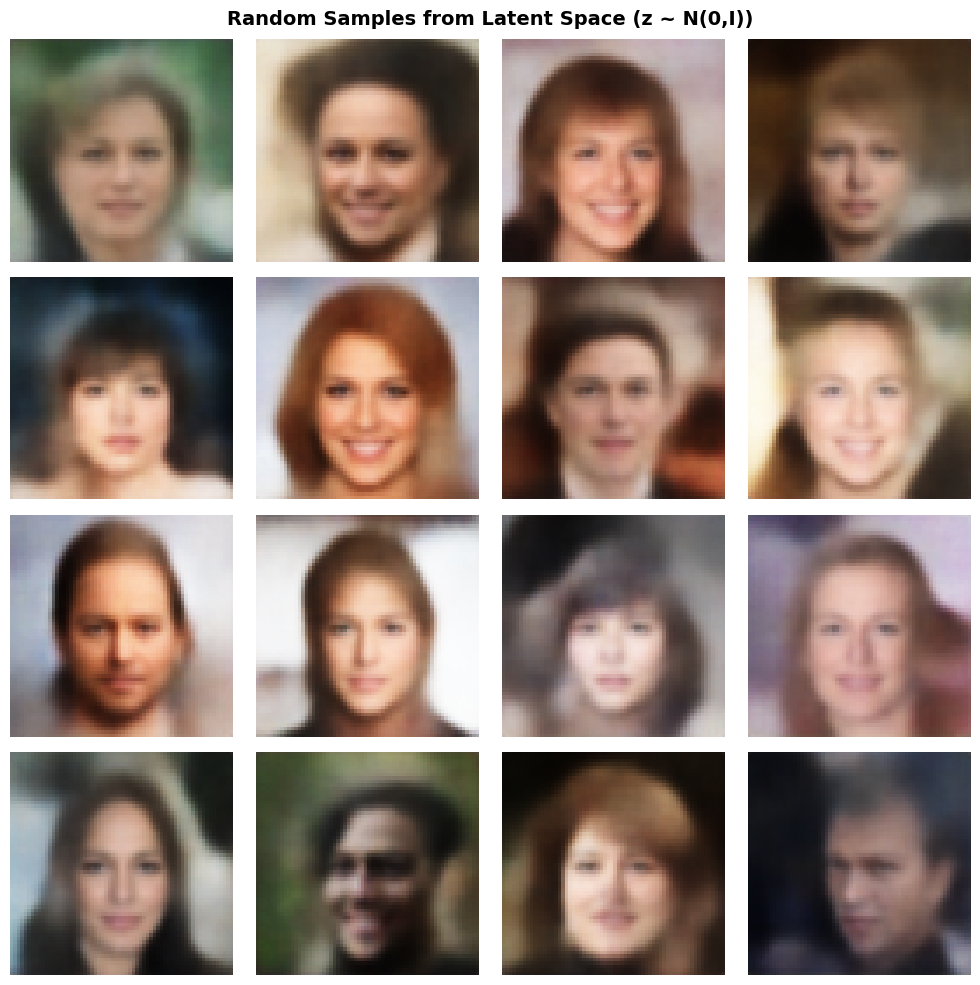

✅ Random samples displayed above

Generating Latent Space Interpolations


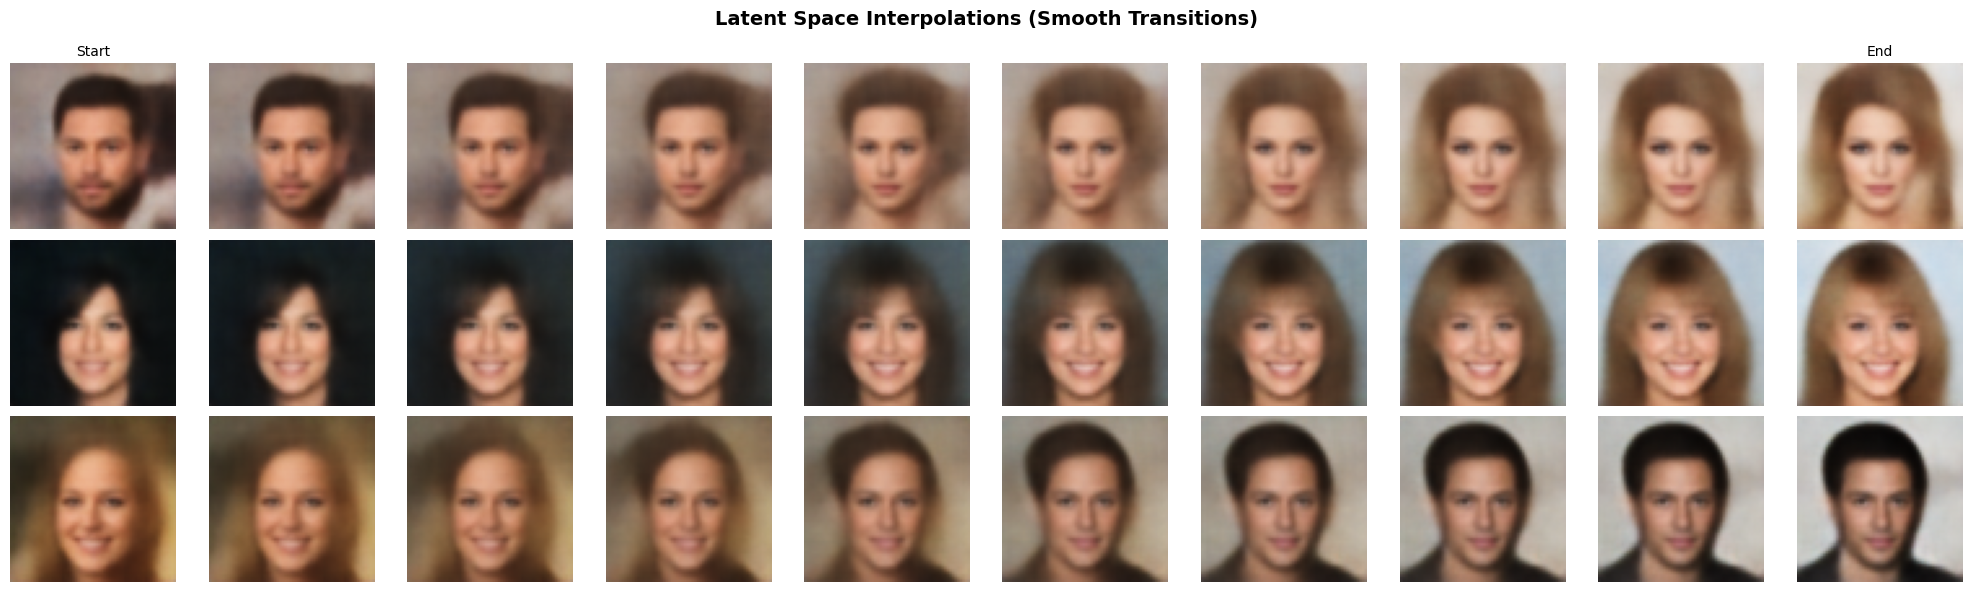

✅ Interpolations displayed above

Generating Latent Dimension Traversals


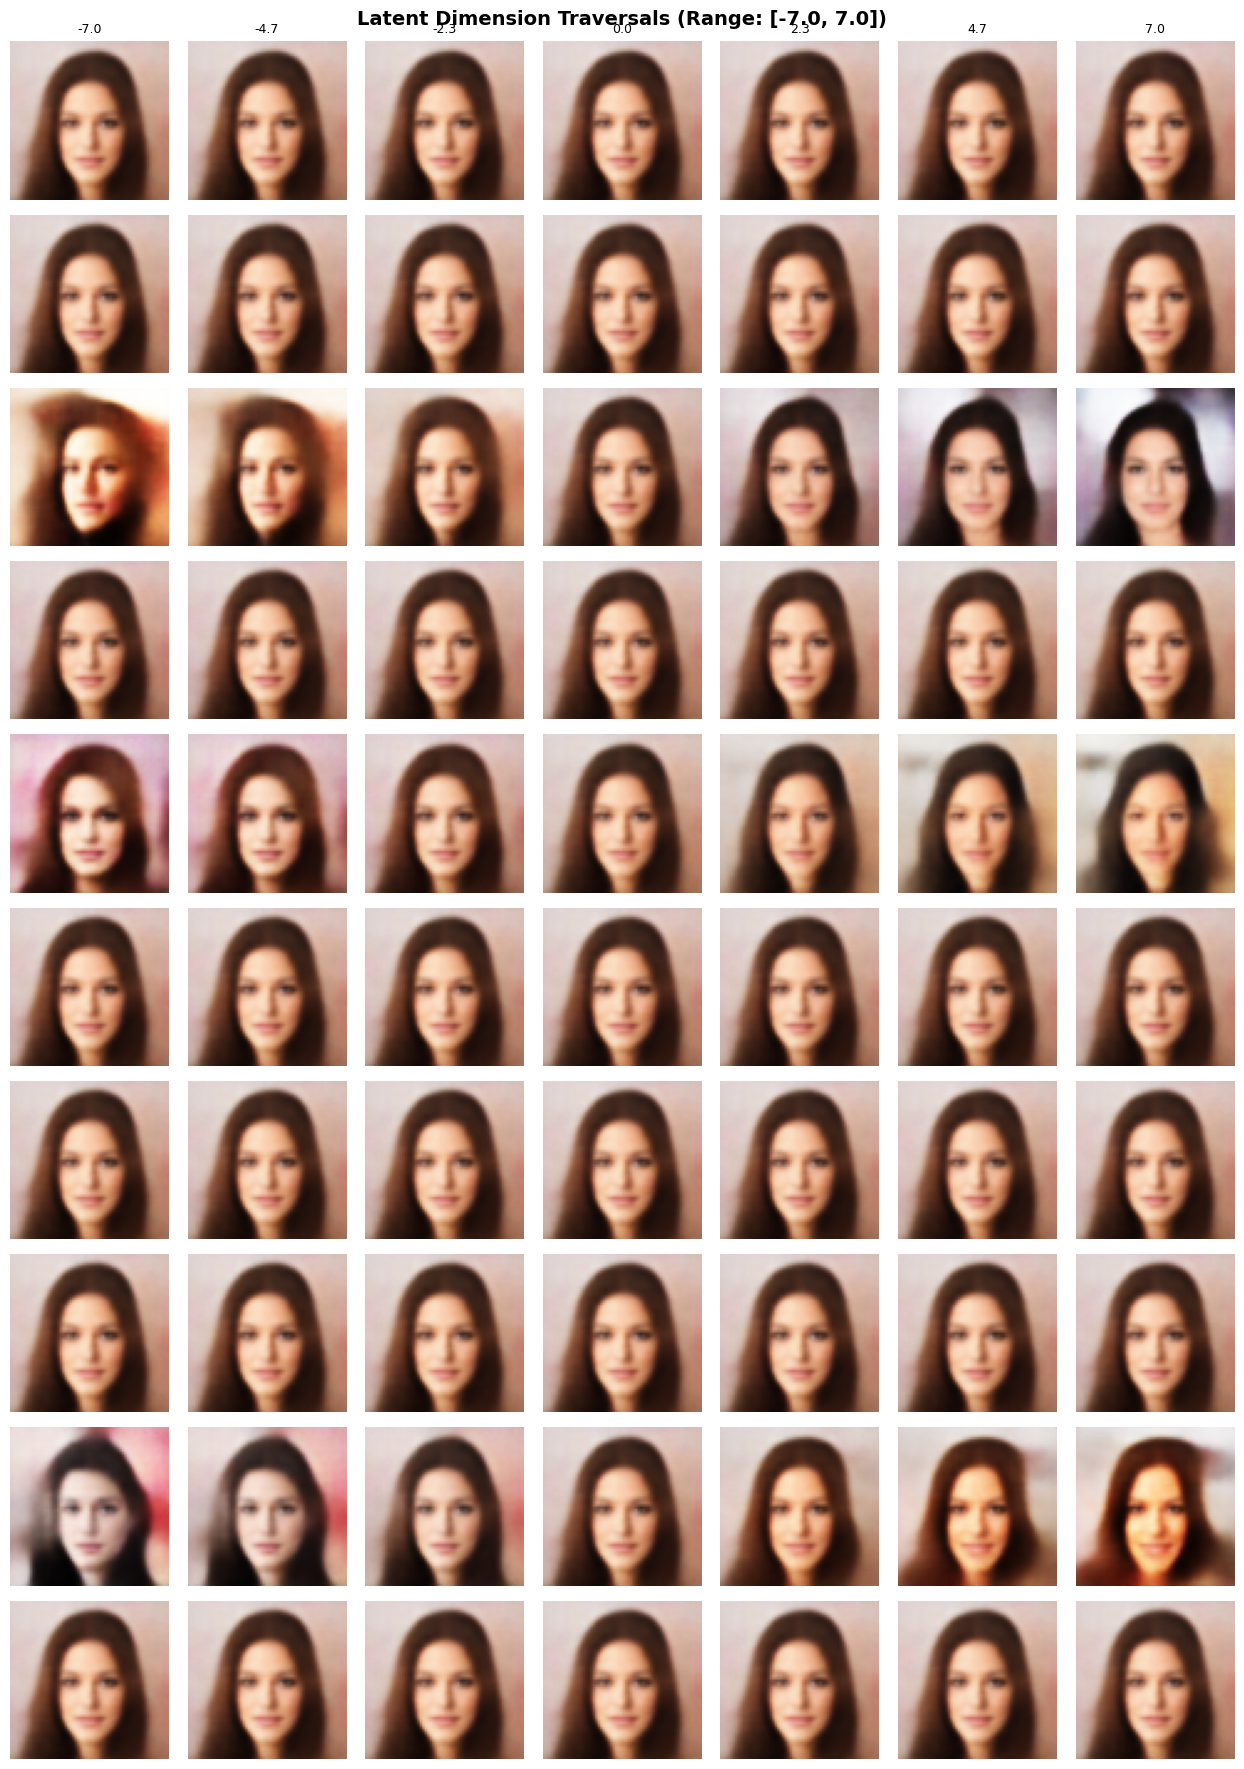

✅ Latent traversals displayed above
   Each row shows how varying a single latent dimension affects the generated face

Computing Reconstruction Quality Metrics
✅ Reconstruction Quality Metrics (on 10 test batches):
   Mean Squared Error (MSE): 0.008670
   Mean Absolute Error (MAE): 0.063713

Testing Complete - Summary

📊 Model Information:
   Latent Dimension: 128
   Image Size: 64×64
   Training Epochs: 44
   Beta (β): 1.0

📈 Performance:
   Best Validation Loss: 6348.0464
   Test MSE: 0.008670
   Test MAE: 0.063713

✅ Generated Visualizations:
   1. ✓ Original vs. Reconstructed (10 samples)
   2. ✓ Random Samples from Latent Space (16 samples)
   3. ✓ Latent Space Interpolations (3 pairs)
   4. ✓ Latent Dimension Traversals (10 dimensions)

💾 Model checkpoint location:
   ./outputs/vae_baseline_latent128_20251231_170110/checkpoints/best_model.pth

🎉 Phase 1 Task 1 & 2 Complete!

📝 Next Steps for Portfolio 3:
   - Task 3: Train β-VAE variants (β=4, β=10)
   - Part 2: Answer theory qu

In [ ]:
"""
SECOND CELL - VAE Testing and Visualization
"""

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import glob



print("=" * 60)
print("VAE Model Testing and Visualization")
print("=" * 60)

# ============================================================================
# Configuration
# ============================================================================

output_dirs = glob.glob('./outputs_512/vae_baseline_latent512_*')
if not output_dirs:
    raise FileNotFoundError("No output directories found! Make sure training completed.")

output_dir = sorted(output_dirs)[-1]  
checkpoint_dir = os.path.join(output_dir, 'checkpoints')
print(f"\nUsing output directory: {output_dir}")

# Check which checkpoint to use
best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
final_model_path = os.path.join(checkpoint_dir, 'final_model.pth')

if os.path.exists(best_model_path):
    checkpoint_path = best_model_path
    print(f"Loading BEST model: {checkpoint_path}")
elif os.path.exists(final_model_path):
    checkpoint_path = final_model_path
    print(f"Loading FINAL model: {checkpoint_path}")
else:
    # Find latest checkpoint
    checkpoints = glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pth'))
    if checkpoints:
        checkpoint_path = sorted(checkpoints)[-1]
        print(f"Loading latest checkpoint: {checkpoint_path}")
    else:
        raise FileNotFoundError("No checkpoints found!")

# ============================================================================
# Load Model
# ============================================================================

print("\n" + "=" * 60)
print("Loading Trained Model")
print("=" * 60)

checkpoint = torch.load(checkpoint_path, map_location=device)
config = checkpoint['config']

# Create model
model = VAE(latent_dim=config['latent_dim']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Model loaded successfully!")
print(f"   Epoch: {checkpoint['epoch']}")
print(f"   Latent dimension: {config['latent_dim']}")
if 'val_loss' in checkpoint:
    print(f"   Validation loss: {checkpoint['val_loss']:.4f}")

# ============================================================================
# Load Test Dataset
# ============================================================================

print("\n" + "=" * 60)
print("Loading Test Dataset")
print("=" * 60)

celeba_root = './CelebA'
partition_file = os.path.join(celeba_root, 'Eval', 'list_eval_partition.txt')

transform = transforms.Compose([
    transforms.Resize(config['img_size']),
    transforms.CenterCrop(config['img_size']),
    transforms.ToTensor(),
])

test_dataset = CelebADataset(
    root_dir=celeba_root,
    partition_file=partition_file,
    split='test',
    transform=transform,
    subset_size=2000  # Use 2000 test images
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0 
)

print(f"✅ Test dataset loaded: {len(test_dataset)} images")

# ============================================================================
# Visualization 1: Reconstructions
# ============================================================================

print("\n" + "=" * 60)
print("Generating Reconstructions")
print("=" * 60)

def visualize_reconstructions(model, dataset, num_samples=10):
    """Visualize original and reconstructed images"""
    model.eval()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img = dataset[idx].unsqueeze(0).to(device)
            recon, _, _ = model(img)
            
            # Original
            img_np = img[0].cpu().permute(1, 2, 0).numpy()
            axes[0, i].imshow(img_np)
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_ylabel('Original', fontsize=12, fontweight='bold')
            
            # Reconstruction
            recon_np = recon[0].cpu().permute(1, 2, 0).numpy()
            axes[1, i].imshow(recon_np)
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_ylabel('Reconstructed', fontsize=12, fontweight='bold')
    
    plt.suptitle('VAE Reconstructions on Test Set', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

fig1 = visualize_reconstructions(model, test_dataset, num_samples=10)
print("✅ Reconstructions displayed above")

# ============================================================================
# Visualization 2: Random Samples from Latent Space
# ============================================================================

print("\n" + "=" * 60)
print("Generating Random Samples from Latent Space")
print("=" * 60)

def generate_random_samples(model, num_samples=16):
    """Generate random samples from the latent space"""
    model.eval()
    
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(num_samples, model.latent_dim).to(device)
        samples = model.decode(z).cpu()
    
    # Plot
    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2.5, grid_size * 2.5))
    axes = axes.flatten()
    
    for i in range(num_samples):
        sample_np = samples[i].permute(1, 2, 0).numpy()
        axes[i].imshow(sample_np)
        axes[i].axis('off')
    
    plt.suptitle('Random Samples from Latent Space (z ~ N(0,I))', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

fig2 = generate_random_samples(model, num_samples=16)
print("✅ Random samples displayed above")

# ============================================================================
# Visualization 3: Latent Space Interpolation
# ============================================================================

print("\n" + "=" * 60)
print("Generating Latent Space Interpolations")
print("=" * 60)

def interpolate_latent(model, dataset, num_pairs=3, num_steps=10):
    """Interpolate between pairs of images in latent space"""
    model.eval()
    
    fig, axes = plt.subplots(num_pairs, num_steps, figsize=(num_steps * 2, num_pairs * 2))
    
    with torch.no_grad():
        for pair_idx in range(num_pairs):
            # Get two random images
            idx1, idx2 = np.random.choice(len(dataset), 2, replace=False)
            img1 = dataset[idx1].unsqueeze(0).to(device)
            img2 = dataset[idx2].unsqueeze(0).to(device)
            
            # Encode to latent space
            mu1, _ = model.encode(img1)
            mu2, _ = model.encode(img2)
            
            # Interpolate
            alphas = np.linspace(0, 1, num_steps)
            
            for step_idx, alpha in enumerate(alphas):
                # Linear interpolation in latent space
                z_interp = (1 - alpha) * mu1 + alpha * mu2
                
                # Decode
                img_interp = model.decode(z_interp)
                
                # Display
                img_np = img_interp[0].cpu().permute(1, 2, 0).numpy()
                
                if num_pairs == 1:
                    axes[step_idx].imshow(img_np)
                    axes[step_idx].axis('off')
                    if step_idx == 0:
                        axes[step_idx].set_title('Start', fontsize=10)
                    elif step_idx == num_steps - 1:
                        axes[step_idx].set_title('End', fontsize=10)
                else:
                    axes[pair_idx, step_idx].imshow(img_np)
                    axes[pair_idx, step_idx].axis('off')
                    
                    if step_idx == 0:
                        axes[pair_idx, step_idx].set_ylabel(f'Pair {pair_idx+1}', fontsize=10, fontweight='bold')
                    if pair_idx == 0:
                        if step_idx == 0:
                            axes[pair_idx, step_idx].set_title('Start', fontsize=10)
                        elif step_idx == num_steps - 1:
                            axes[pair_idx, step_idx].set_title('End', fontsize=10)
    
    plt.suptitle('Latent Space Interpolations (Smooth Transitions)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

fig3 = interpolate_latent(model, test_dataset, num_pairs=3, num_steps=10)
print("✅ Interpolations displayed above")

# ============================================================================
# Visualization 4: Latent Dimension Traversals
# ============================================================================

print("\n" + "=" * 60)
print("Generating Latent Dimension Traversals")
print("=" * 60)

def traverse_latent_dims(model, dataset, num_dims=10, num_steps=7, traversal_range=3.0):
    """
    Traverse individual latent dimensions to see their effect
    Shows what each dimension controls in the generated images
    """
    model.eval()
    
    with torch.no_grad():
        # Get a random image and encode it
        idx = np.random.choice(len(dataset))
        img = dataset[idx].unsqueeze(0).to(device)
        mu, _ = model.encode(img)
        
        # Select random dimensions to traverse
        dims_to_traverse = np.random.choice(model.latent_dim, num_dims, replace=False)
        
        fig, axes = plt.subplots(num_dims, num_steps, figsize=(num_steps * 1.8, num_dims * 1.8))
        
        traversal_values = np.linspace(-traversal_range, traversal_range, num_steps)
        
        for dim_idx, dim in enumerate(dims_to_traverse):
            for step_idx, value in enumerate(traversal_values):
                # Copy the latent vector and modify one dimension
                z_modified = mu.clone()
                z_modified[0, dim] = value
                
                # Decode
                img_generated = model.decode(z_modified)
                img_np = img_generated[0].cpu().permute(1, 2, 0).numpy()
                
                # Display
                axes[dim_idx, step_idx].imshow(img_np)
                axes[dim_idx, step_idx].axis('off')
                
                if step_idx == 0:
                    axes[dim_idx, step_idx].set_ylabel(f'Dim {dim}', fontsize=9, fontweight='bold')
                
                if dim_idx == 0:
                    axes[dim_idx, step_idx].set_title(f'{value:.1f}', fontsize=9)
        
        plt.suptitle(f'Latent Dimension Traversals (Range: [{-traversal_range:.1f}, {traversal_range:.1f}])', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    return fig

fig4 = traverse_latent_dims(model, test_dataset, num_dims=10, num_steps=7, traversal_range=7.0) #TOBECHANGEDANDCHECKED - abcd
print("✅ Latent traversals displayed above")
print("   Each row shows how varying a single latent dimension affects the generated face")

# ============================================================================
# Compute Reconstruction Quality Metrics
# ============================================================================

print("\n" + "=" * 60)
print("Computing Reconstruction Quality Metrics")
print("=" * 60)

def compute_reconstruction_metrics(model, test_loader, num_batches=10):
    """Compute average reconstruction metrics on test set"""
    model.eval()
    
    mse_total = 0
    mae_total = 0
    n_samples = 0
    
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            if batch_idx >= num_batches:
                break
            
            data = data.to(device)
            recon, _, _ = model(data)
            
            # MSE (Mean Squared Error)
            mse = torch.mean((recon - data) ** 2, dim=[1, 2, 3])
            mse_total += mse.sum().item()
            
            # MAE (Mean Absolute Error)
            mae = torch.mean(torch.abs(recon - data), dim=[1, 2, 3])
            mae_total += mae.sum().item()
            
            n_samples += data.size(0)
    
    avg_mse = mse_total / n_samples
    avg_mae = mae_total / n_samples
    
    return avg_mse, avg_mae

avg_mse, avg_mae = compute_reconstruction_metrics(model, test_loader, num_batches=10)

print(f"✅ Reconstruction Quality Metrics (on {10} test batches):")
print(f"   Mean Squared Error (MSE): {avg_mse:.6f}")
print(f"   Mean Absolute Error (MAE): {avg_mae:.6f}")

# ============================================================================
# Summary
# ============================================================================

print("\n" + "=" * 60)
print("Testing Complete - Summary")
print("=" * 60)

print(f"\n📊 Model Information:")
print(f"   Latent Dimension: {config['latent_dim']}")
print(f"   Image Size: {config['img_size']}×{config['img_size']}")
print(f"   Training Epochs: {checkpoint['epoch']}")
print(f"   Beta (β): {config['beta']}")

print(f"\n📈 Performance:")
if 'val_loss' in checkpoint:
    print(f"   Best Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"   Test MSE: {avg_mse:.6f}")
print(f"   Test MAE: {avg_mae:.6f}")

print(f"\n✅ Generated Visualizations:")
print(f"   1. ✓ Original vs. Reconstructed (10 samples)")
print(f"   2. ✓ Random Samples from Latent Space (16 samples)")
print(f"   3. ✓ Latent Space Interpolations (3 pairs)")
print(f"   4. ✓ Latent Dimension Traversals (10 dimensions)")

print(f"\n💾 Model checkpoint location:")
print(f"   {checkpoint_path}")

print("\n" + "=" * 60)